Running simulations WITHOUT satellite launches...
In time step 0, 0 new satellites were launched, total nodes = 1003 

In time step 5, 0 new satellites were launched, total nodes = 1042 

In time step 10, 0 new satellites were launched, total nodes = 1085 

In time step 15, 0 new satellites were launched, total nodes = 1123 

In time step 20, 0 new satellites were launched, total nodes = 1184 

In time step 25, 0 new satellites were launched, total nodes = 1244 

In time step 30, 0 new satellites were launched, total nodes = 1317 

In time step 35, 0 new satellites were launched, total nodes = 1400 

In time step 40, 0 new satellites were launched, total nodes = 1478 

In time step 45, 0 new satellites were launched, total nodes = 1572 

In time step 50, 0 new satellites were launched, total nodes = 1703 

In time step 55, 0 new satellites were launched, total nodes = 1826 

In time step 60, 0 new satellites were launched, total nodes = 1945 

In time step 65, 0 new satellites were lau

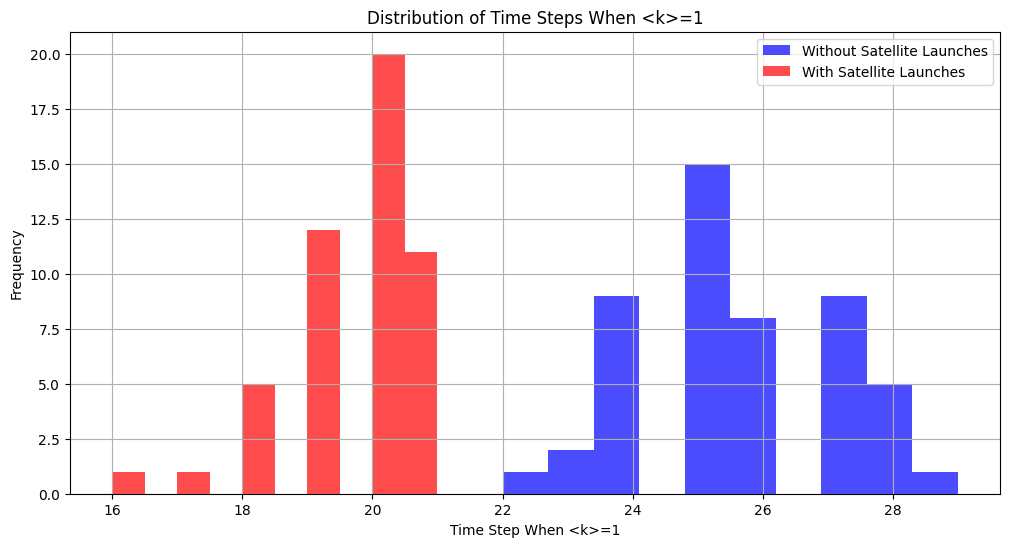

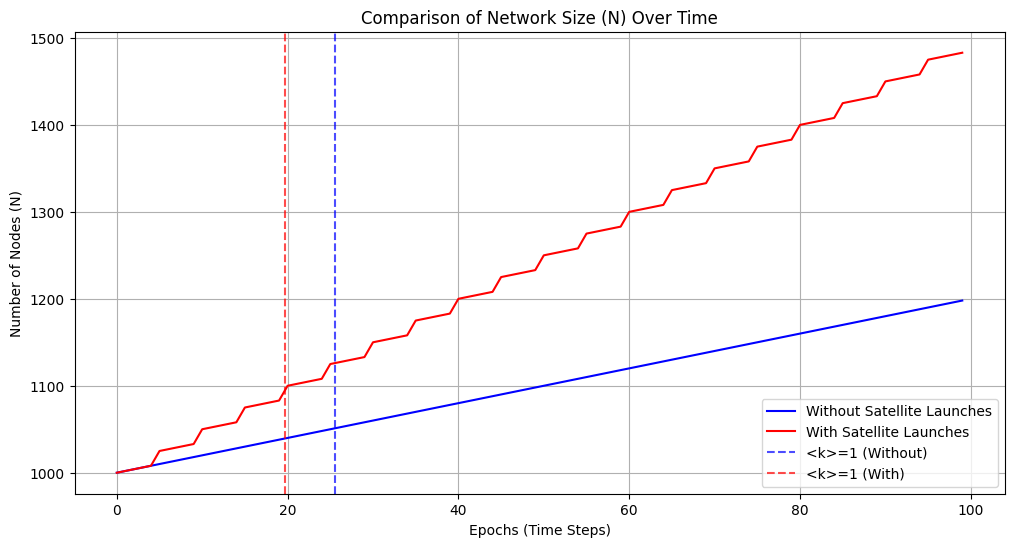

/var/folders/sq/c9xq2zk97n3cf_nqf5x49c0w0000gn/T/ipykernel_43214/2406186153.py:104: RuntimeWarning: Mean of empty slice
  plt.plot(range(iterations), np.nanmean(gc_proportions_without_all, axis=0), label="Without Satellite Launches", color="blue")
/var/folders/sq/c9xq2zk97n3cf_nqf5x49c0w0000gn/T/ipykernel_43214/2406186153.py:105: RuntimeWarning: Mean of empty slice
  plt.plot(range(iterations), np.nanmean(gc_proportions_with_all, axis=0), label="With Satellite Launches", color="red")


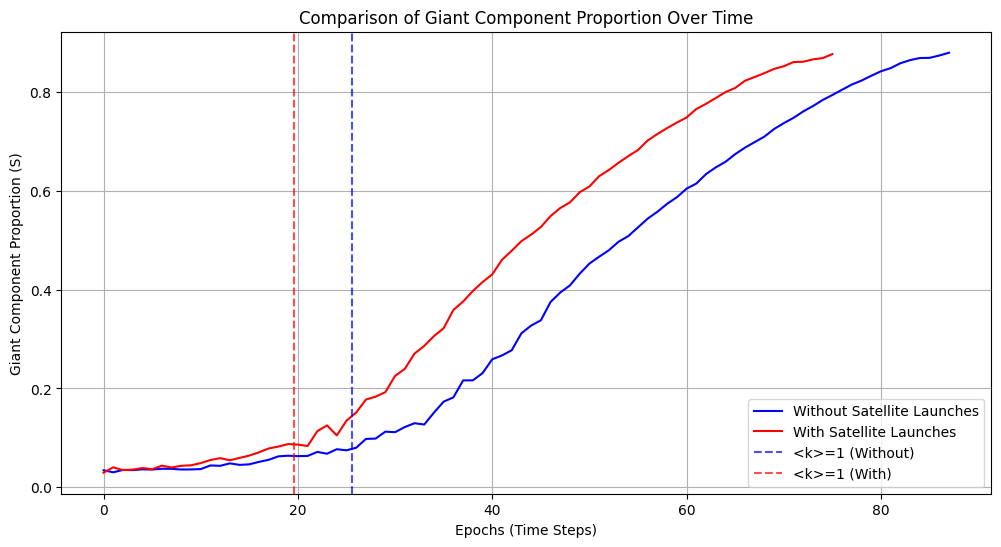

In [21]:
import matplotlib.pyplot as plt
from network.network import dynamic_network_model
import networkx as nx
import numpy as np
from scipy.stats import mannwhitneyu

# Parameters
N = 1000  # Initial number of nodes
P = 0.0008  # Collision probability
plow = 0.01  # Probability of generating new fragments
new_fragments_per_collision = 2  # Debris per collision
iterations = 100  # Number of time steps
launch_freq = 5  # Launch satellites every 5 time steps
nr_sat_launches = 15  # Number of satellites launched per launch
num_simulations = 50  # Number of simulations to average

# Initialize arrays to store results across simulations
nodes_over_time_without_all = []
nodes_over_time_with_all = []
avg_degrees_without_all = []
avg_degrees_with_all = []
gc_proportions_without_all = []
gc_proportions_with_all = []
k_equal_1_timesteps_without = []
k_equal_1_timesteps_with = []

# Run simulations without satellite launches
print("Running simulations WITHOUT satellite launches...")
for _ in range(num_simulations):
    G_without_sat = nx.empty_graph(N)
    avg_degrees_without, gc_proportions_without, _ = dynamic_network_model(
        G_without_sat, iterations, P, plow, new_fragments_per_collision, nr_sat_launches=0, launch_freq=launch_freq
    )
    avg_degrees_without_all.append(np.pad(avg_degrees_without, (0, iterations - len(avg_degrees_without)), constant_values=np.nan))
    gc_proportions_without_all.append(np.pad(gc_proportions_without, (0, iterations - len(gc_proportions_without)), constant_values=np.nan))
    nodes_over_time_without = [N + i * new_fragments_per_collision for i in range(iterations)]
    nodes_over_time_without_all.append(nodes_over_time_without)
    
    k_equal_1_timestep = next((i for i, k in enumerate(avg_degrees_without) if k >= 1), None)
    if k_equal_1_timestep is not None:
        k_equal_1_timesteps_without.append(k_equal_1_timestep)

# Run simulations with satellite launches
print("Running simulations WITH satellite launches...")
for _ in range(num_simulations):
    G_with_sat = nx.empty_graph(N)
    avg_degrees_with, gc_proportions_with, _ = dynamic_network_model(
        G_with_sat, iterations, P, plow, new_fragments_per_collision, nr_sat_launches, launch_freq
    )
    avg_degrees_with_all.append(np.pad(avg_degrees_with, (0, iterations - len(avg_degrees_with)), constant_values=np.nan))
    gc_proportions_with_all.append(np.pad(gc_proportions_with, (0, iterations - len(gc_proportions_with)), constant_values=np.nan))
    nodes_over_time_with = [
        N + i * new_fragments_per_collision + (i // launch_freq) * nr_sat_launches for i in range(iterations)
    ]
    nodes_over_time_with_all.append(nodes_over_time_with)
    
    k_equal_1_timestep = next((i for i, k in enumerate(avg_degrees_with) if k >= 1), None)
    if k_equal_1_timestep is not None:
        k_equal_1_timesteps_with.append(k_equal_1_timestep)

# Perform Mann-Whitney U test
stat, p_value = mannwhitneyu(k_equal_1_timesteps_without, k_equal_1_timesteps_with, alternative='greater')

print("Mann-Whitney U Test Results:")
print(f"U Statistic: {stat}")
print(f"P-Value: {p_value}")

# Compute U statistic range
n1, n2 = len(k_equal_1_timesteps_without), len(k_equal_1_timesteps_with)
U_min, U_max = 0, n1 * n2
print(f"U Statistic Range: {U_min} to {U_max}")

# Plot statistical frequency distribution
plt.figure(figsize=(12, 6))
plt.hist(k_equal_1_timesteps_without, alpha=0.7, label="Without Satellite Launches", color="blue", bins=10)
plt.hist(k_equal_1_timesteps_with, alpha=0.7, label="With Satellite Launches", color="red", bins=10)
plt.xlabel("Time Step When <k>=1")
plt.ylabel("Frequency")
plt.title("Distribution of Time Steps When <k>=1")
plt.legend()
plt.grid(True)
plt.show()

# Plot the results for network size over time
plt.figure(figsize=(12, 6))
plt.plot(range(iterations), np.nanmean(nodes_over_time_without_all, axis=0), label="Without Satellite Launches", color="blue")
plt.plot(range(iterations), np.nanmean(nodes_over_time_with_all, axis=0), label="With Satellite Launches", color="red")

# Add horizontal lines for <k>=1 timesteps
if k_equal_1_timesteps_without:
    plt.axvline(x=np.mean(k_equal_1_timesteps_without), color="blue", linestyle="--", alpha=0.7, label="<k>=1 (Without)")
if k_equal_1_timesteps_with:
    plt.axvline(x=np.mean(k_equal_1_timesteps_with), color="red", linestyle="--", alpha=0.7, label="<k>=1 (With)")

plt.xlabel("Epochs (Time Steps)")
plt.ylabel("Number of Nodes (N)")
plt.title("Comparison of Network Size (N) Over Time")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot the results for giant component proportion over time
plt.figure(figsize=(12, 6))
plt.plot(range(iterations), np.nanmean(gc_proportions_without_all, axis=0), label="Without Satellite Launches", color="blue")
plt.plot(range(iterations), np.nanmean(gc_proportions_with_all, axis=0), label="With Satellite Launches", color="red")

# Add horizontal lines for <k>=1 timesteps
if k_equal_1_timesteps_without:
    plt.axvline(x=np.mean(k_equal_1_timesteps_without), color="blue", linestyle="--", alpha=0.7, label="<k>=1 (Without)")
if k_equal_1_timesteps_with:
    plt.axvline(x=np.mean(k_equal_1_timesteps_with), color="red", linestyle="--", alpha=0.7, label="<k>=1 (With)")

plt.xlabel("Epochs (Time Steps)")
plt.ylabel("Giant Component Proportion (S)")
plt.title("Comparison of Giant Component Proportion Over Time")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()